# BMEN4460 Final Project: Free interaction data

In [2]:
# Import Necessary Packages
import h5py
import scipy.io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Free Interaction

**Step 1: Load Data**

In [3]:
# Define file paths
neuron_data_path = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_9-2/neuron_pDA_1_phototag.mat"
events_uni_path = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_9-2/events_Unilateral.mat"
events_rec_path = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_9-2/events_Reciprocal.mat"
events_pass_path = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_9-2/events_Passive.mat"

# Load in spike data
neuron_data = scipy.io.loadmat(neuron_data_path)
neuron_timestamps = neuron_data['times']
neuron_features = neuron_data['shape']

# Load in event timings
events_unilateral = scipy.io.loadmat(events_uni_path)['events_Unilateral']
events_reciprocal = scipy.io.loadmat(events_rec_path)['events_Reciprocal']
events_passive = scipy.io.loadmat(events_pass_path)['events_Passive']

In [4]:
# DATASET 2

# Define file paths
neuron_data_path_2 = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_8-1/neuron_pDA_1_phototag.mat"
events_uni_path_2 = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_8-1/events_Unilateral.mat"
events_rec_path_2 = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_8-1/events_Reciprocal.mat"
events_pass_path_2 = "/content/drive/My Drive/Spring 2024/Deep Learning/Final Project Deep Learning/Data/Free_Interaction/ID_8-1/events_Passive.mat"

# Load in spike data
neuron_data_2 = scipy.io.loadmat(neuron_data_path_2)
neuron_timestamps_2 = neuron_data_2['times']
neuron_features_2 = neuron_data_2['shape']

# Load in event timings
events_unilateral_2 = scipy.io.loadmat(events_uni_path_2)['events_Unilateral']
events_reciprocal_2 = scipy.io.loadmat(events_rec_path_2)['events_Reciprocal']
events_passive_2 = scipy.io.loadmat(events_pass_path_2)['events_Passive']

In [5]:
# Dataset 1: Flatten 2D Arrays into 1D arrays
neuron_timestamps = neuron_timestamps.flatten()
events_unilateral = events_unilateral.flatten()
events_reciprocal = events_reciprocal.flatten()
events_passive = events_passive.flatten()

# Dataset 2: Flatten 2D Arrays into 1D arrays
neuron_timestamps_2 = neuron_timestamps_2.flatten()
events_unilateral_2 = events_unilateral_2.flatten()
events_reciprocal_2 = events_reciprocal_2.flatten()
events_passive_2 = events_passive_2.flatten()

In [6]:
# Check shapes
print("Neuron time shape (Datset 1): ", neuron_timestamps.shape)
print("Neuron feature shape (Dataset 1): ", neuron_features.shape)
print("Events Unilateral shape (Dataset 1): ", events_unilateral.shape)
print("Events Reciprocal shape (Dataset 1): ", events_reciprocal.shape)
print("Events Passive shape (Dataset 1): ", events_passive.shape)
print("\n")
print("Neuron time shape (Dataset 2): ", neuron_timestamps_2.shape)
print("Neuron feature shape (Dataset 2): ", neuron_features_2.shape)
print("Events Unilateral shape (Dataset 2): ", events_unilateral_2.shape)
print("Events Reciprocal shape (Dataset 2): ", events_reciprocal_2.shape)
print("Events Passive shape (Dataset 2): ", events_passive_2.shape)

Neuron time shape (Datset 1):  (1746,)
Neuron feature shape (Dataset 1):  (61, 1746)
Events Unilateral shape (Dataset 1):  (175,)
Events Reciprocal shape (Dataset 1):  (189,)
Events Passive shape (Dataset 1):  (62,)


Neuron time shape (Dataset 2):  (3118,)
Neuron feature shape (Dataset 2):  (61, 3118)
Events Unilateral shape (Dataset 2):  (57,)
Events Reciprocal shape (Dataset 2):  (118,)
Events Passive shape (Dataset 2):  (58,)


**Step 2: Identify Event Instances**

In [7]:
# Helper functions

# Function to segment the event timestamps into instances based on the time gap threshold
def segment_events(event_timestamps, threshold):
  instances = [] # Initialize list of instances
  start_time = event_timestamps[0] # Initialize starting time of instances

  for i in range(1, len(event_timestamps)):
    if event_timestamps[i] - event_timestamps[i-1] > threshold:
      end_time = event_timestamps[i-1] # End current instance
      instances.append((start_time, end_time)) # Append start and end times to instance list
      start_time = event_timestamps[i] # Start new instance

  instances.append((start_time, event_timestamps[-1])) # Append last instance

  return instances

# Function to extract neural timestamps for each event instance
def extract_timestamps(instances, neuron_timestamps):
  timestamps_list = [] # Initialize list of timestamps

  for start_time, end_time in instances:
    indices = np.where((neuron_timestamps >= start_time) & (neuron_timestamps <= end_time))[0] # Identify instance indices
    if indices.size > 0:
      instance_timestamps = neuron_timestamps[indices] # Extract the timestamps for these indices
      timestamps_list.append(instance_timestamps)

  return timestamps_list


In [8]:
# Use helper function to extract timestamps for each instance

# DATASET 1

# Define event gap threshold
threshold = 0.5

# Find unilateral event timestamps
instances_unilateral = segment_events(events_unilateral, threshold)
timestamps_unilateral = extract_timestamps(instances_unilateral, neuron_timestamps)

# Find reciprocal event timestamps
instances_reciprocal = segment_events(events_reciprocal, threshold)
timestamps_reciprocal = extract_timestamps(instances_reciprocal, neuron_timestamps)

# Find passive event timestamps
instances_passive = segment_events(events_passive, threshold)
timestamps_passive = extract_timestamps(instances_passive, neuron_timestamps)


# DATASET 2

# Find unilateral event timestamps
instances_unilateral_2 = segment_events(events_unilateral_2, threshold)
timestamps_unilateral_2 = extract_timestamps(instances_unilateral_2, neuron_timestamps)

# Find reciprocal event timestamps
instances_reciprocal_2 = segment_events(events_reciprocal_2, threshold)
timestamps_reciprocal_2 = extract_timestamps(instances_reciprocal_2, neuron_timestamps)

# Find passive event timestamps
instances_passive_2 = segment_events(events_passive_2, threshold)
timestamps_passive_2 = extract_timestamps(instances_passive_2, neuron_timestamps)

**Step 3: Encoding Labels**

In [9]:
# Define dictionary to map event types to numeric codes
event_type_codes = event_type_codes = {
    'unilateral': 1,
    'reciprocal': 2,
    'passive': 3,
    'unilateral_reciprocal': 4,
    'unilateral_passive': 5,
    'reciprocal_passive': 6,
    'all' : 7
}

# Helper function to encode event type
def encode_event_type(event_instances, event_code, neuron_timestamps, event_encoding):
    # Define dictionary for mapping existing and new event codes to combined event codes
    combined_event_codes = {
        (1, 2): 4,
        (1, 3): 5,
        (2, 3): 6,
        (4, 3): 7,  # unilateral_reciprocal (4) with passive (3)
        (5, 2): 7,  # unilateral_passive (5) with reciprocal (2)
        (6, 1): 7,  # reciprocal_passive (6) with unilateral (1)
    }

    for start_time, end_time in event_instances:
        # Find indices where events fall within the specified start and end times
        indices = np.where((neuron_timestamps >= start_time) & (neuron_timestamps <= end_time))[0]

        # Update event_encoding based on the existing code at the indices and the new event_code
        for index in indices:
            existing_code = event_encoding[index]
            # Check if there's an existing event code and if a combination is needed
            if existing_code in [1, 2, 3, 4, 5, 6] and existing_code != event_code:
                # Determine the combined code based on existing and new event codes
                new_code = combined_event_codes.get((existing_code, event_code), event_code)
                event_encoding[index] = new_code
            elif existing_code == 0:  # If no event has been recorded yet
                event_encoding[index] = event_code


In [10]:
# DATASET 1

# Initialize the event encoding array with zeros
event_encoding = np.zeros(len(neuron_timestamps), dtype = int)

# Use helper functions to encode event state
encode_event_type(instances_unilateral, event_type_codes['unilateral'], neuron_timestamps, event_encoding)
encode_event_type(instances_reciprocal, event_type_codes['reciprocal'], neuron_timestamps, event_encoding)
encode_event_type(instances_passive, event_type_codes['passive'], neuron_timestamps, event_encoding)

# DATASET 2

# Initialize the event encoding array with zeros
event_encoding_2 = np.zeros(len(neuron_timestamps_2), dtype = int)

# Use helper functions to encode event state
encode_event_type(instances_unilateral_2, event_type_codes['unilateral'], neuron_timestamps_2, event_encoding_2)
encode_event_type(instances_reciprocal_2, event_type_codes['reciprocal'], neuron_timestamps_2, event_encoding_2)
encode_event_type(instances_passive_2, event_type_codes['passive'], neuron_timestamps_2, event_encoding_2)

**Step 4: Combine Data**

In [11]:
# DATASET 1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(neuron_features.T)

data_df = pd.DataFrame(scaled_features, columns=[f'Feature_{i+1}' for i in range(scaled_features.shape[1])])
data_df['Timestamp'] = neuron_timestamps
data_df['Event'] = event_encoding
data_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Timestamp,Event
0,0.906146,0.893563,0.489088,0.111965,0.211988,0.740393,1.143223,1.036651,0.413683,-0.302846,...,0.004023,-0.140003,-0.330563,-0.163061,0.288112,0.545597,0.374402,0.056916,0.167187,0
1,0.825112,0.313265,-0.293892,-0.848094,-1.190278,-1.246135,-1.106445,-0.942450,-0.764167,-0.371291,...,-0.601175,-1.125220,-1.351053,-1.066259,-0.379470,0.208246,0.354004,0.171570,0.885750,0
2,-0.201312,0.083895,0.448763,0.898889,1.132983,0.838480,0.164475,-0.427243,-0.650500,-0.571536,...,-0.976833,0.391993,1.176607,0.966899,0.167349,-0.267519,0.118047,0.935933,1.231031,0
3,0.713691,1.390255,1.583468,1.062180,0.125429,-0.439400,-0.290129,0.186765,0.456514,0.236231,...,-0.118185,-0.437774,-0.521209,-0.016657,0.894749,1.497127,1.338629,0.628550,1.232250,0
4,0.428949,-0.051416,-0.716185,-1.042654,-0.715931,-0.095547,0.189903,-0.058424,-0.619201,-0.980510,...,0.619316,0.827358,0.509343,0.002607,-0.297645,-0.157684,0.311002,0.825646,1.760937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,-1.160770,-0.597062,0.165367,1.020489,1.782757,2.191853,2.080454,1.580309,0.895257,0.352191,...,-1.038469,-0.753926,-0.663665,-0.911598,-1.424578,-1.787278,-1.577206,-0.732561,597.762031,0
1742,-0.569901,-1.183961,-1.205128,-1.119667,-1.506509,-2.274390,-2.669535,-2.342202,-1.557637,-1.155865,...,1.590608,1.705966,1.800446,1.648287,1.196092,0.675045,0.323682,0.124617,598.038375,0
1743,-0.944118,-0.852283,-0.412067,0.030898,0.345290,0.708432,1.294757,2.037582,2.656815,2.649913,...,1.489122,1.126179,0.367946,-0.274792,-0.596731,-0.716386,-0.756869,-0.548568,598.803719,1
1744,0.226928,0.278612,0.274581,0.168712,-0.092125,-0.470810,-0.806489,-0.942450,-0.736162,-0.146157,...,0.840354,0.720224,0.650739,0.533738,0.246353,-0.154322,-0.458615,-0.534373,599.053625,1


In [12]:
# DATASET 2
scaler_2 = StandardScaler()
scaled_features_2 = scaler.fit_transform(neuron_features_2.T)

data_df_2 = pd.DataFrame(scaled_features_2, columns=[f'Feature_{i+1}' for i in range(scaled_features_2.shape[1])])
data_df_2['Timestamp'] = neuron_timestamps_2
data_df_2['Event'] = event_encoding_2
data_df_2

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Timestamp,Event
0,-1.682214,-0.342274,1.050692,1.846338,1.605013,0.604621,-0.367937,-0.544335,0.156920,1.134647,...,1.334096,0.903341,0.138611,-0.565158,-0.885738,-0.784119,-0.463037,-0.120334,0.108906,0
1,0.212984,0.460359,0.774824,0.830773,0.432698,-0.184954,-0.481650,-0.025377,0.991790,1.859145,...,0.286841,0.433007,-0.004455,-0.920154,-1.691120,-1.738846,-1.079374,-0.128149,0.481594,0
2,0.527792,0.701149,0.475818,-0.028345,-0.503010,-0.753700,-0.874642,-1.119249,-1.578544,-1.967329,...,0.022604,0.447679,0.960410,1.236342,1.002744,0.278608,-0.628312,-1.346443,0.661250,0
3,-0.231557,-0.297683,-0.398952,-0.550431,-0.618188,-0.491410,-0.221475,-0.038013,-0.115745,-0.379413,...,0.624613,1.854607,2.504195,2.330416,1.506975,0.507570,-0.271938,-0.676077,0.812094,0
4,1.004994,0.166060,-1.155365,-2.284759,-2.641391,-2.184130,-1.267634,-0.434225,-0.055350,-0.055851,...,1.844794,2.122787,2.093295,1.894155,1.633684,1.320600,0.886706,0.279107,1.186219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,-2.653855,-2.608373,-2.137812,-1.866375,-1.835146,-1.601863,-0.786401,0.330221,1.048632,1.054636,...,-0.948693,0.007505,0.628530,0.641830,0.285884,0.042735,0.115424,0.318183,599.112687,0
3114,0.151293,0.033180,-0.043882,-0.107016,-0.336047,-0.823104,-1.302203,-1.249214,-0.441700,0.696783,...,-0.324865,0.370241,0.591100,0.470747,0.435158,0.805652,1.465167,1.964573,599.390094,0
3115,0.213891,0.427362,1.460045,2.630361,2.917505,1.968351,0.291598,-1.118347,-1.667359,-1.557601,...,-0.593951,-0.210137,0.423912,0.927538,0.738044,-0.123154,-0.874502,-0.776806,599.599625,0
3116,-0.953711,0.413093,1.422669,1.587977,0.897874,0.065619,-0.000417,0.980046,2.189917,2.428016,...,-0.053355,-0.651126,-1.345285,-1.613039,-1.171267,-0.359892,0.089600,-0.282715,599.873969,0


In [13]:
# Visualize the combined data
data_df = pd.concat([data_df, data_df_2], ignore_index = True)
data_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Timestamp,Event
0,0.906146,0.893563,0.489088,0.111965,0.211988,0.740393,1.143223,1.036651,0.413683,-0.302846,...,0.004023,-0.140003,-0.330563,-0.163061,0.288112,0.545597,0.374402,0.056916,0.167187,0
1,0.825112,0.313265,-0.293892,-0.848094,-1.190278,-1.246135,-1.106445,-0.942450,-0.764167,-0.371291,...,-0.601175,-1.125220,-1.351053,-1.066259,-0.379470,0.208246,0.354004,0.171570,0.885750,0
2,-0.201312,0.083895,0.448763,0.898889,1.132983,0.838480,0.164475,-0.427243,-0.650500,-0.571536,...,-0.976833,0.391993,1.176607,0.966899,0.167349,-0.267519,0.118047,0.935933,1.231031,0
3,0.713691,1.390255,1.583468,1.062180,0.125429,-0.439400,-0.290129,0.186765,0.456514,0.236231,...,-0.118185,-0.437774,-0.521209,-0.016657,0.894749,1.497127,1.338629,0.628550,1.232250,0
4,0.428949,-0.051416,-0.716185,-1.042654,-0.715931,-0.095547,0.189903,-0.058424,-0.619201,-0.980510,...,0.619316,0.827358,0.509343,0.002607,-0.297645,-0.157684,0.311002,0.825646,1.760937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,-2.653855,-2.608373,-2.137812,-1.866375,-1.835146,-1.601863,-0.786401,0.330221,1.048632,1.054636,...,-0.948693,0.007505,0.628530,0.641830,0.285884,0.042735,0.115424,0.318183,599.112687,0
4860,0.151293,0.033180,-0.043882,-0.107016,-0.336047,-0.823104,-1.302203,-1.249214,-0.441700,0.696783,...,-0.324865,0.370241,0.591100,0.470747,0.435158,0.805652,1.465167,1.964573,599.390094,0
4861,0.213891,0.427362,1.460045,2.630361,2.917505,1.968351,0.291598,-1.118347,-1.667359,-1.557601,...,-0.593951,-0.210137,0.423912,0.927538,0.738044,-0.123154,-0.874502,-0.776806,599.599625,0
4862,-0.953711,0.413093,1.422669,1.587977,0.897874,0.065619,-0.000417,0.980046,2.189917,2.428016,...,-0.053355,-0.651126,-1.345285,-1.613039,-1.171267,-0.359892,0.089600,-0.282715,599.873969,0


**Step 5: Apply Windowing**

In [14]:
# Define window size and step size
window_size = 4
step_size = 1

# Function to create windows in the data, returns most common label for each window
def create_windows(df, window_size, step_size):
  windows = []
  labels = []

  for start in range(0, df.shape[0] - window_size + 1, step_size):
    end = start + window_size
    window_df = df.iloc[start:end]

    most_common_label = window_df['Event'].mode()[0]
    windows.append(window_df.drop(['Timestamp', 'Event'], axis=1).values)
    labels.append(most_common_label)

  return np.array(windows), np.array(labels)

In [15]:
# Create windows using helper functions
X, Y = create_windows(data_df, window_size, step_size)

**Step 6: Balance Classes**

In [16]:
from imblearn.over_sampling import SMOTE

classes_to_augment = [1, 2, 3]

# Calculate the current class distribution
class_distribution = np.bincount(Y.flatten())  # Assuming Y is 1D and contains class labels
majority_class_count = class_distribution.max()

# Create a dictionary for SMOTE where only specific minority classes are set to match the majority
sampling_strategy = {cls: majority_class_count for cls in classes_to_augment if class_distribution[cls] < majority_class_count}

# Reshape X for SMOTE (if necessary)
X_reshaped_for_smote = X.reshape(X.shape[0], -1)

# Create and apply SMOTE with the custom strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_augmented_reshaped, Y_augmented = smote.fit_resample(X_reshaped_for_smote, Y)

# Reshape X back to 3D if needed
X_augmented = X_augmented_reshaped.reshape(-1, X.shape[1], X.shape[2])

**Step 7: Define and Train Model**

In [17]:
n_features = 61

# Prepare data for a ConvLSTM
X_reshaped = X_augmented.reshape(X_augmented.shape[0], window_size, 1, 1, n_features)
y_encoded = to_categorical(Y_augmented, num_classes = len(event_type_codes) + 1)

# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

In [19]:
# Define ConvLSTM Model
model = Sequential([
    ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        activation='relu',
        input_shape=(window_size,1, 1, n_features),
        return_sequences=False
    ),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(
        100,
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.4),
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          32256     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [20]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
477/477 [==============================] - 10s 15ms/step - loss: 0.3015 - accuracy: 0.9077 - precision: 0.9389 - recall: 0.8728 - auc: 0.9938 - val_loss: 0.0440 - val_accuracy: 0.9942 - val_precision: 0.9942 - val_recall: 0.9940 - val_auc: 1.0000
Epoch 2/100
477/477 [==============================] - 7s 14ms/step - loss: 0.0616 - accuracy: 0.9862 - precision: 0.9868 - recall: 0.9856 - auc: 0.9996 - val_loss: 0.0257 - val_accuracy: 0.9963 - val_precision: 0.9963 - val_recall: 0.9963 - val_auc: 1.0000
Epoch 3/100
477/477 [==============================] - 11s 23ms/step - loss: 0.0395 - accuracy: 0.9937 - precision: 0.9940 - recall: 0.9932 - auc: 0.9997 - val_loss: 0.0220 - val_accuracy: 0.9976 - val_precision: 0.9976 - val_recall: 0.9976 - val_auc: 0.9998
Epoch 4/100
477/477 [==============================] - 6s 12ms/step - loss: 0.0319 - accuracy: 0.9948 - precision: 0.9950 - recall: 0.9948 - auc: 0.9998 - val_loss: 0.0211 - val_accuracy: 0.9976 - val_precision: 0.9976 - val

In [25]:
# Print out test loss and accuracy to assess model
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss}, \n Test Accuracy: {test_accuracy}")
print(f"Training Metrics: {history.history.keys()}")

120/120 [==============================] - 1s 6ms/step - loss: 0.0048 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9995 - auc: 0.9999
Training Metrics: dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


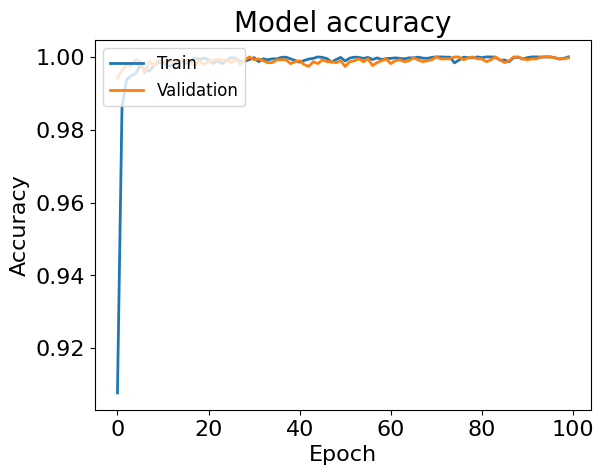

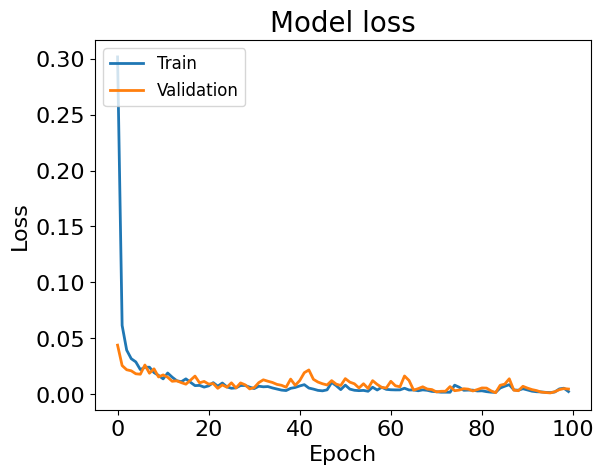

In [29]:
plt.rcParams.update({'font.size': 16})

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Model loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.show()

Step _: Visualization

In [30]:
# Make predictions
y_pred = model.predict(X_test)

120/120 [==============================] - 1s 7ms/step


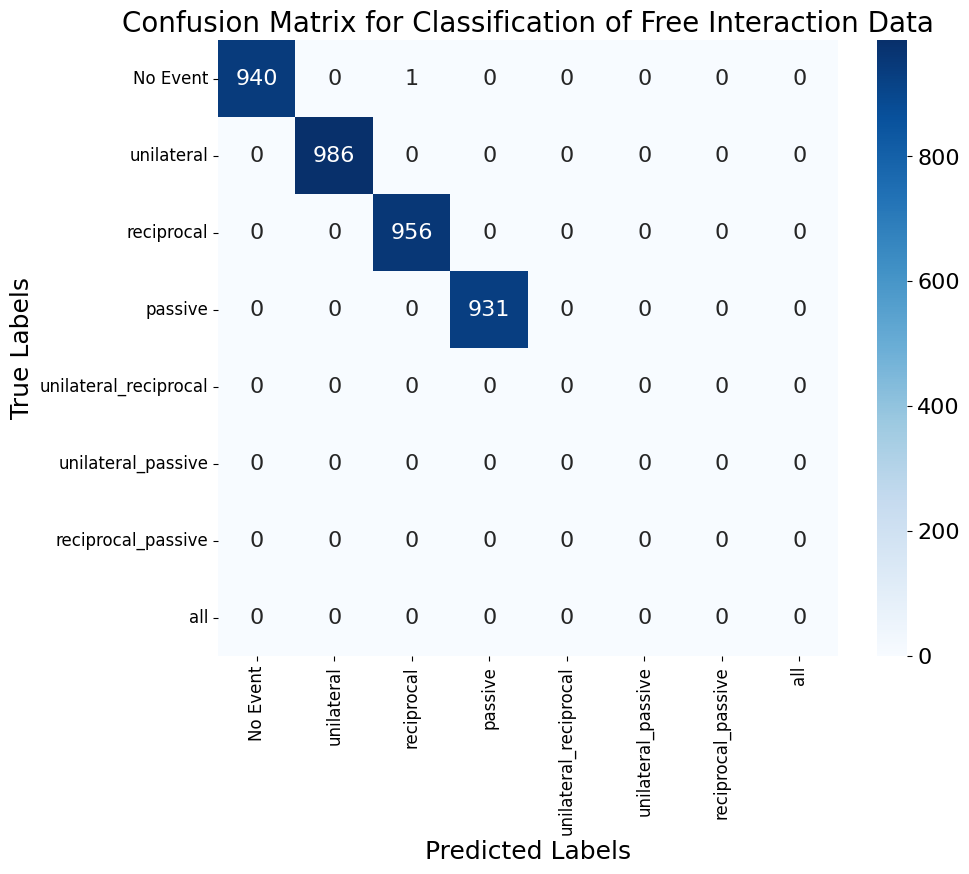

In [35]:
# y_test is  true labels and predictions are model's predictions
y_true_indices = np.argmax(y_test, axis=1)
y_pred_indices = np.argmax(y_pred, axis=1)

# Define the full list of classes
classes = [0, 1, 2, 3, 4, 5, 6, 7]
event_type_codes = {
    0: 'No Event',
    1: 'unilateral',
    2: 'reciprocal',
    3: 'passive',
    4: 'unilateral_reciprocal',
    5: 'unilateral_passive',
    6: 'reciprocal_passive',
    7: 'all'
}

# Generate the confusion matrix with all labels
conf_matrix = confusion_matrix(y_true_indices, y_pred_indices, labels=classes)
class_labels = [event_type_codes[i] for i in classes]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Classification of Free Interaction Data', fontsize=20)
plt.ylabel('True Labels', fontsize = 18)
plt.xlabel('Predicted Labels', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(len(classes)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(classes)) + 0.5, minor=False)

plt.show()

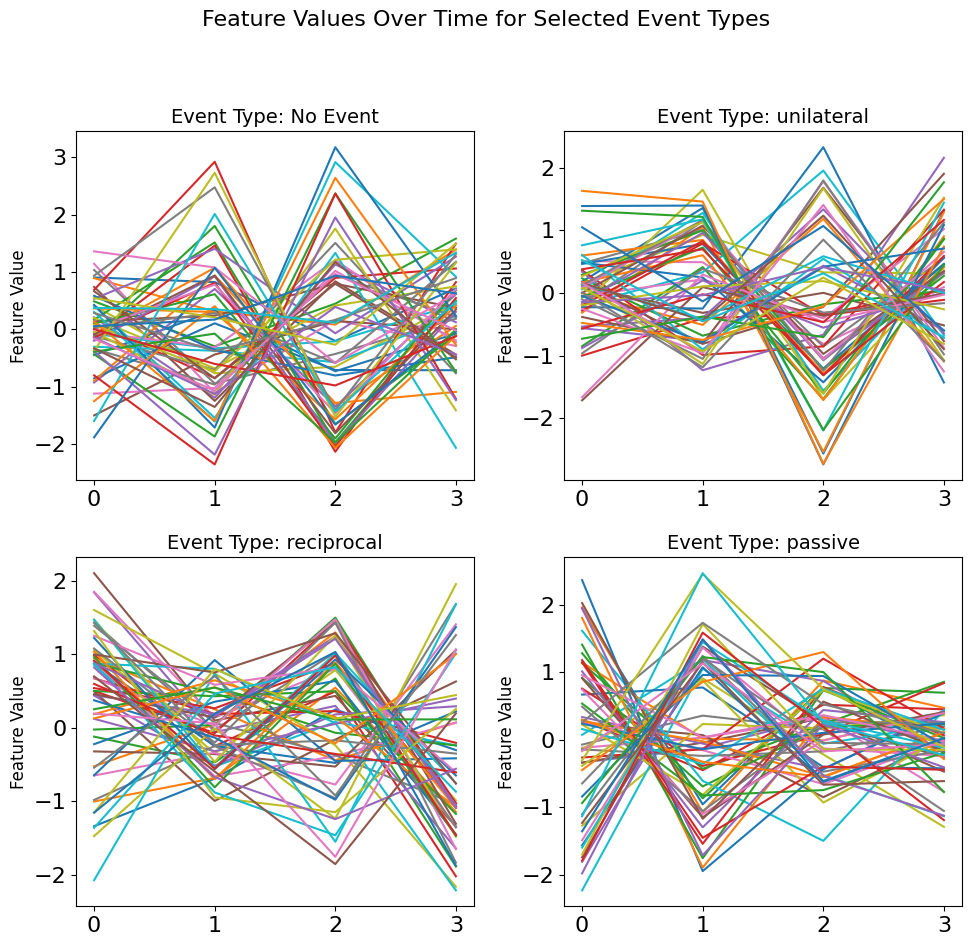

In [56]:
unique_events = [0, 1, 2, 3]

# Selecting one example window for each specified event type
example_windows = {}
for event in unique_events:
    index = np.where(Y == event)[0][0]
    example_windows[event] = X[index]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Feature Values Over Time for Selected Event Types', fontsize=16)

if len(example_windows) == 1:
    axs = [axs]

axs = axs.flatten()

for ax, (event, window) in zip(axs, example_windows.items()):
    n_features = window.shape[1]
    for feature_idx in range(n_features):
        ax.plot(window[:, feature_idx], label=f'Feature {feature_idx+1}')
    ax.set_title(f'Event Type: {event_type_codes[event]}', fontsize=14)
    ax.set_ylabel('Feature Value', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()